In [135]:
import pandas as pd 
# from graphviz import Diagraph
import numpy as np
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

In [136]:
df = pd.read_csv('mutations_1.csv')

In [137]:
# data = df
# data['class'] = data['class'].str.startswith('C').astype(int)
# data

### Calculate the total of samples and probability of Occurence

In [138]:
def Sample_sum(classes):
    # Assuming 'classes' is a numpy array containing the class labels
    classes = classes.astype(str)
    cancer_mask = np.char.startswith(classes, 'C')
    cancer_total = cancer_mask.sum()
    non_cancer_total = (~cancer_mask).sum()
    
    return cancer_total, non_cancer_total


In [139]:
def Probability(df):
    sample_total = len(df)
    cancer_total, non_cancer_total = Sample_sum(df['class'].values)
    if sample_total == 0:  # Handle empty DataFrame
        return 0, 0
    probability_C = cancer_total/sample_total
    probability_NC = non_cancer_total/sample_total
    
    return probability_C, probability_NC

In [140]:
total_df = len(df)
t_c, t_nc = Sample_sum(df['class'].values)
pC, pNC = Probability(df)
print(f"""For the root note, t \n
Total Number of Samples, n(t): {total_df} \n
Total Cancer Samples, n(t, C): {t_c} \n
Total NonCancer Samples, n(t, NC): {t_nc} \n
Probability of Selecting C Sample at Node, p(C|t): {pC} \n
Probability of Selecting NC Sample at Node, p(NC|t): {pNC}
""")

For the root note, t 

Total Number of Samples, n(t): 250 

Total Cancer Samples, n(t, C): 108 

Total NonCancer Samples, n(t, NC): 142 

Probability of Selecting C Sample at Node, p(C|t): 0.432 

Probability of Selecting NC Sample at Node, p(NC|t): 0.568



### Splitting and Computations

In [141]:
def Split_and_Compute(df):
    sample_total = len(df)
    classes = df['class'].values  # Convert to numpy array for faster processing
    results = []

    # Iterate over columns using numpy operations
    for column in df.columns[1:]:
        # Split data based on column feature into two groups
        feature_values = df[column].values
        left_mask = feature_values == 1
        right_mask = ~left_mask  # No need to compare to zero

        # Calculate total samples, cancer and non-cancer in each split
        left_cancer_tot, left_non_cancer_tot = Sample_sum(classes[left_mask])
        right_cancer_tot, right_non_cancer_tot = Sample_sum(classes[right_mask])
        
        # Calculate Proportions
        left_sum = left_mask.sum()
        right_sum = right_mask.sum()
        PL = left_sum / sample_total
        PR = right_sum / sample_total
        
        # Calculate Probabilities with numpy division that handles division by zero
        Prob_C_left, Prob_NC_left = np.divide([left_cancer_tot, left_non_cancer_tot], left_sum, out=np.zeros(2), where=left_sum != 0)

        Prob_C_right, Prob_NC_right = np.divide([right_cancer_tot, right_non_cancer_tot], right_sum, out=np.zeros(2), where=right_sum != 0)

        
        Q = abs(Prob_C_left - Prob_C_right) + abs(Prob_NC_left - Prob_NC_right)
        
        # Append results for this feature to the list
        results.append([left_sum, right_sum, left_cancer_tot, left_non_cancer_tot, PL, PR, Prob_C_left, 
                        Prob_NC_left, Prob_C_right, Prob_NC_right, 2*PL*PR, Q, 2*PL*PR*Q])
    
    # Convert results list to DataFrame
    result_df = pd.DataFrame(results, columns=['n(tL)', 'n(tR)', 'n(tL,C)', 'n(tL,NC)', 'PL', 'PR', 
                                               'P(C|tL)', 'P(NC|tL)', 'P(C|tR)', 'P(NC|tR)', '2PLPR', 'Q', 'Phi(s|t)'],
                             index=df.columns[1:])
    feature_table = result_df.sort_values(by='Phi(s|t)', ascending=False)
    
    return feature_table


In [142]:
table_1 = Split_and_Compute(df)

In [143]:
table_1.head(10)

,n(tL),n(tR),"n(tL,C)","n(tL,NC)",PL,PR,P(C|tL),P(NC|tL),P(C|tR),P(NC|tR),2PLPR,Q,Phi(s|t)
RPL22_GRCh37_1:6257785-6257785_Frame-Shift-Del_DEL_T-T--,28,222,27,1,0.112,0.888,0.964286,0.035714,0.364865,0.635135,0.198912,1.198842,0.238464
DOCK3_GRCh37_3:51417604-51417604_Frame-Shift-Del_DEL_C-C--,23,227,22,1,0.092,0.908,0.956522,0.043478,0.378855,0.621145,0.167072,1.155334,0.193024
RNF43_GRCh37_17:56435161-56435161_Frame-Shift-Del_DEL_C-C--,23,227,22,1,0.092,0.908,0.956522,0.043478,0.378855,0.621145,0.167072,1.155334,0.193024
PPP2R1A_GRCh37_19:52715971-52715971_Missense-Mutation_SNP_C-C-G_C-C-T,24,226,0,24,0.096,0.904,0.000000,1.000000,0.477876,0.522124,0.173568,0.955752,0.165888
KRAS_GRCh37_12:25398284-25398284_Missense-Mutation_SNP_C-C-A_C-C-T_C-C-G,28,222,22,6,0.112,0.888,0.785714,0.214286,0.387387,0.612613,0.198912,0.796654,0.158464
NCOA3_GRCh37_20:46282985-46282985_3'Flank_DEL_T-T--,15,235,15,0,0.060,0.940,1.000000,0.000000,0.395745,0.604255,0.112800,1.208511,0.136320
DRD5_GRCh37_4:9785349-9785349_3'UTR_SNP_G-G-C,14,236,14,0,0.056,0.944,1.000000,0.000000,0.398305,0.601695,0.105728,1.203390,0.127232
CTNNA2_GRCh37_2:80875615-80875615_3'UTR_DEL_T-T--,13,237,13,0,0.052,0.948,1.000000,0.000000,0.400844,0.599156,0.098592,1.198312,0.118144
ACVR2A_GRCh37_2:148683686-148683686_Frame-Shift-Del_DEL_A-A--,13,237,13,0,0.052,0.948,1.000000,0.000000,0.400844,0.599156,0.098592,1.198312,0.118144
CSNK1G1_GRCh37_15:64461260-64461260_3'UTR_DEL_A-A--,13,237,13,0,0.052,0.948,1.000000,0.000000,0.400844,0.599156,0.098592,1.198312,0.118144


In [144]:
root_node = table_1.index[0]
root_node

'RPL22_GRCh37_1:6257785-6257785_Frame-Shift-Del_DEL_T-T--'

### find the left and right child of the root node based on F(s,t)

#### samples in left and right child, and their respective feature tables ordered by top F(s,t)

In [145]:
left_child = df[df[root_node]==1]
right_child = df[df[root_node]==0]

In [146]:
left_child

,class,GOT1_GRCh37_10:101163586-101163586_Missense-Mutation_SNP_C-C-T,TEX36_GRCh37_10:127371546-127371546_Nonsense-Mutation_SNP_G-G-A,KIAA1217_GRCh37_10:24810824-24810824_Missense-Mutation_SNP_C-C-T,SIRT1_GRCh37_10:69676051-69676051_Missense-Mutation_SNP_C-C-T,MYPN_GRCh37_10:69881845-69881845_Missense-Mutation_SNP_C-C-T,LARP4B_GRCh37_10:890939-890939_Frame-Shift-Del_DEL_T-T--,NPAT_GRCh37_11:108032094-108032094_Missense-Mutation_SNP_G-G-T_G-G-A,ARNTL_GRCh37_11:13402723-13402723_Silent_SNP_G-G-A,COPB1_GRCh37_11:14480092-14480092_Missense-Mutation_SNP_G-G-A_G-G-T,...,FBXO21_GRCh37_12:117624320-117624320_Frame-Shift-Del_DEL_A-A--,CLRN1_GRCh37_3:150644691-150644691_3'UTR_DEL_A-A--,VPS37A_GRCh37_8:17153149-17153149_3'UTR_DEL_A-A--,VANGL2_GRCh37_1:160398257-160398258_3'UTR_INS_----G,SRGAP3_GRCh37_3:9023972-9023972_3'UTR_DEL_A-A--,PTENP1_GRCh37_9:33674774-33674774_RNA_DEL_T-T--,KMT2C_GRCh37_7:151836804-151836804_Nonsense-Mutation_SNP_G-G-A,CDKN1C_GRCh37_11:2904846-2904846_3'UTR_DEL_T-T--,PIK3R2_GRCh37_19:18278070-18278070_Missense-Mutation_SNP_A-A-G,LMO7_GRCh37_13:76432354-76432354_3'UTR_SNP_C-C-T
8,C3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,C5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32,C11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35,C13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38,C15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41,C18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49,C21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60,C24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64,C26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70,C27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [147]:
left_feature_table = Split_and_Compute(left_child)
left_feature_table

,n(tL),n(tR),"n(tL,C)","n(tL,NC)",PL,PR,P(C|tL),P(NC|tL),P(C|tR),P(NC|tR),2PLPR,Q,Phi(s|t)
HGSNAT_GRCh37_8:43002099-43002099_Frame-Shift-Del_DEL_A-A--,1,27,0,1,0.035714,0.964286,0.0,1.0,1.000000,0.000000,0.068878,2.0,0.137755
CAPS2_GRCh37_12:75669988-75669988_3'UTR_DEL_T-T--,1,27,0,1,0.035714,0.964286,0.0,1.0,1.000000,0.000000,0.068878,2.0,0.137755
FAT3_GRCh37_11:92616097-92616097_Missense-Mutation_SNP_G-G-A,1,27,0,1,0.035714,0.964286,0.0,1.0,1.000000,0.000000,0.068878,2.0,0.137755
TNS3_GRCh37_7:47474967-47474967_Silent_SNP_C-C-T,1,27,0,1,0.035714,0.964286,0.0,1.0,1.000000,0.000000,0.068878,2.0,0.137755
TTC14_GRCh37_3:180327408-180327408_Intron_DEL_T-T--,1,27,0,1,0.035714,0.964286,0.0,1.0,1.000000,0.000000,0.068878,2.0,0.137755
...,...,...,...,...,...,...,...,...,...,...,...,...,...
MIR1283-1_GRCh37_19:54191812-54191812_RNA_SNP_G-G-A,0,28,0,0,0.000000,1.000000,0.0,0.0,0.964286,0.035714,0.000000,1.0,0.000000
FPR3_GRCh37_19:52327411-52327411_Missense-Mutation_SNP_G-G-A,0,28,0,0,0.000000,1.000000,0.0,0.0,0.964286,0.035714,0.000000,1.0,0.000000
NAPSA_GRCh37_19:50865026-50865026_Missense-Mutation_SNP_C-C-T,0,28,0,0,0.000000,1.000000,0.0,0.0,0.964286,0.035714,0.000000,1.0,0.000000
MYH14_GRCh37_19:50758526-50758526_Silent_SNP_G-G-A,0,28,0,0,0.000000,1.000000,0.0,0.0,0.964286,0.035714,0.000000,1.0,0.000000


In [148]:
right_feature_table = Split_and_Compute(right_child)
right_feature_table

,n(tL),n(tR),"n(tL,C)","n(tL,NC)",PL,PR,P(C|tL),P(NC|tL),P(C|tR),P(NC|tR),2PLPR,Q,Phi(s|t)
DOCK3_GRCh37_3:51417604-51417604_Frame-Shift-Del_DEL_C-C--,14,208,14,0,0.063063,0.936937,1.000000,0.000000,0.322115,0.677885,0.118172,1.355769,0.160214
PPP2R1A_GRCh37_19:52715971-52715971_Missense-Mutation_SNP_C-C-G_C-C-T,24,198,0,24,0.108108,0.891892,0.000000,1.000000,0.409091,0.590909,0.192841,0.818182,0.157779
RNF43_GRCh37_17:56435161-56435161_Frame-Shift-Del_DEL_C-C--,15,207,14,1,0.067568,0.932432,0.933333,0.066667,0.323671,0.676329,0.126004,1.219324,0.153640
KRAS_GRCh37_12:25398284-25398284_Missense-Mutation_SNP_C-C-A_C-C-T_C-C-G,22,200,16,6,0.099099,0.900901,0.727273,0.272727,0.325000,0.675000,0.178557,0.804545,0.143657
PTEN_GRCh37_10:89692904-89692904_Missense-Mutation_SNP_C-C-G,13,209,11,2,0.058559,0.941441,0.846154,0.153846,0.334928,0.665072,0.110259,1.022451,0.112734
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SDK2_GRCh37_17:71335062-71335062_Silent_SNP_G-G-A,0,222,0,0,0.000000,1.000000,0.000000,0.000000,0.364865,0.635135,0.000000,1.000000,0.000000
DNAH2_GRCh37_17:7696521-7696521_Nonsense-Mutation_SNP_C-C-T,0,222,0,0,0.000000,1.000000,0.000000,0.000000,0.364865,0.635135,0.000000,1.000000,0.000000
DHRS7C_GRCh37_17:9674865-9674865_Missense-Mutation_SNP_G-G-T,0,222,0,0,0.000000,1.000000,0.000000,0.000000,0.364865,0.635135,0.000000,1.000000,0.000000
CEP76_GRCh37_18:12701088-12701088_Nonsense-Mutation_SNP_C-C-A,0,222,0,0,0.000000,1.000000,0.000000,0.000000,0.364865,0.635135,0.000000,1.000000,0.000000


In [149]:
# left_node,right_node = left_feature_table.index[0], right_feature_table.index[0]
# print(f"The left node of the root is {left_node} \nThe right node of the root is {right_node}")

##### Leaf nodes of decision trees, split by node of the left and right of the root

In [150]:
# leaf_A1 = left_child[left_child[left_node]==1]
# leaf_A2 = left_child[left_child[left_node]==0]
# leaf_B1= right_child[right_child[right_node]==1]
# leaf_B2 = right_child[right_child[right_node]==0]

#### Function to get root node, left, right node

In [151]:
# get tree nodes
def get_tree(df):
    root_node = Split_and_Compute(df).index[0]
    left_child = df[df[root_node]==1]
    right_child = df[df[root_node]==0]
    left_node = Split_and_Compute(left_child).index[0]
    right_node = Split_and_Compute(right_child).index[0]
    return root_node, left_child, right_child, left_node, right_node

#### Lets get the classification conditions now - boolean values

In [152]:
def get_conditions(df):
    root_node, left_child, right_child, left_node, right_node = get_tree(df)
    print(f"The root node of the root is {root_node} \nThe left node of the root is {left_node} \nThe right node of the root is {right_node}")
    leaf_A1 = left_child[left_child[left_node]==1]
    leaf_A2 = left_child[left_child[left_node]==0]
    leaf_B1= right_child[right_child[right_node]==1]
    leaf_B2 = right_child[right_child[right_node]==0]
    
    # conditions
    A1 = leaf_A1['class'].str.startswith('C').astype(int).sum() > leaf_A1['class'].str.startswith('NC').astype(int).sum()
    A2 = leaf_A2['class'].str.startswith('C').astype(int).sum() > leaf_A2['class'].str.startswith('NC').astype(int).sum()
    B1 = leaf_B1['class'].str.startswith('C').astype(int).sum() > leaf_B1['class'].str.startswith('NC').astype(int).sum()
    B2 = leaf_B2['class'].str.startswith('C').astype(int).sum() > leaf_B2['class'].str.startswith('NC').astype(int).sum()
    
    conditions = [A1, A2, B1, B2]
    
    return conditions


### Draw the Decision Tree

In [153]:
# dot = Digraph()

# dot.node('A', root_node[:5])
# dot.node('B', left_node[:5])
# dot.node('C', right_node[:5])
# dot.node('D', 'A1')
# dot.node('E', 'A2')
# dot.node('F', 'B1')
# dot.node('G', 'B2')

# dot.edge('A', 'B')
# dot.edge('A', 'C')
# dot.edge('B', 'D')
# dot.edge('B', 'E')
# dot.edge('C', 'F')
# dot.edge('C', 'G')

# dot.view()

### Classification

In [154]:
conditions = get_conditions(df)

The root node of the root is RPL22_GRCh37_1:6257785-6257785_Frame-Shift-Del_DEL_T-T-- 
The left node of the root is HGSNAT_GRCh37_8:43002099-43002099_Frame-Shift-Del_DEL_A-A-- 
The right node of the root is DOCK3_GRCh37_3:51417604-51417604_Frame-Shift-Del_DEL_C-C--


In [155]:
def Classification(df, sample, tree_nodes, conditions):
    S = df[df['class']==sample]
    root_node, left_node, right_node = tree_nodes
    A1, A2, B1, B2 = conditions
    if S[root_node].iloc[0] == 1:
        if S[left_node].iloc[0]==1:
            if A1: #false
                return "C Sample"
            else:
                return "NC Sample"
        else:
            if A2: #true
                return "C Sample"
            else:
                return "NC Sample"
    else:
        if S[right_node].iloc[0]==1:
            if B1: #true
                return "C Sample"
            else:
                return "NC Sample"
        else:
            if B2: #false
                return "C Sample"
            else:
                return "NC Sample"
        

#### Test Classification Logic on entire data frame here 

In [156]:
# tree_nodes = get_tree()
# Classification(df, 'NC49', tree_nodes, conditions)

In [157]:
# def Classify_test(df, test):
#     # get_tree_nodes
#     root_node = Split_and_Compute(df).index[0]
#     left_child = df[df[root_node]==1]
#     right_child = df[df[root_node]==0]
#     left_node = Split_and_Compute(left_child).index[0]
#     right_node = Split_and_Compute(right_child).index[0]
    
#     # tree_nodes = [root_node, left_node, right_node]
#     root_node, left_node, right_node
    
#     # get conditions
#     leaf_A1 = left_child[left_child[left_node]==1]
#     leaf_A2 = left_child[left_child[left_node]==0]
#     leaf_B1= right_child[right_child[right_node]==1]
#     leaf_B2 = right_child[right_child[right_node]==0]
    
#     # conditions
#     A1 = leaf_A1['class'].str.startswith('C').astype(int).sum() > leaf_A1['class'].str.startswith('NC').astype(int).sum()
#     A2 = leaf_A2['class'].str.startswith('C').astype(int).sum() > leaf_A2['class'].str.startswith('NC').astype(int).sum()
#     B1 = leaf_B1['class'].str.startswith('C').astype(int).sum() > leaf_B1['class'].str.startswith('NC').astype(int).sum()
#     B2 = leaf_B2['class'].str.startswith('C').astype(int).sum() > leaf_B2['class'].str.startswith('NC').astype(int).sum()
    
#     # conditions = [A1, A2, B1, B2]

#     root_mask = df[root_node] == 1
#     left_mask = df[left_node] == 1
#     right_mask = df[right_node] == 1
    
#     data = test.copy()
#     data['predicted_class'] = 'NC Sample'  # Default Value
#     data.loc[root_mask & left_mask, 'predicted_class'] = 'C Sample' if A1 else 'NC Sample'
#     data.loc[root_mask & ~left_mask, 'predicted_class'] = 'C Sample' if A2 else 'NC Sample'
#     data.loc[~root_mask & right_mask, 'predicted_class'] = 'C Sample' if B1 else 'NC Sample'
#     data.loc[~root_mask & ~right_mask, 'predicted_class'] = 'C Sample' if B2 else 'NC Sample'
    
#     classified_map = dict(zip(data['class'], data['predicted_class']))
    
#     return classified_map
    
    # my_map = {}
    # for i in range(len(test)):
    #     check = test.iloc[i]['class']
    #     my_map[check] = Classification(test, test.iloc[i], tree_nodes, conditions)
   
    # return my_map
    


### 3-fold Cross Validation

#### Build tree & Perform Classification

In [158]:
def build_tree_and_conditions(df):
    root_node = Split_and_Compute(df).index[0]
    left_child = df[df[root_node]==1]
    right_child = df[df[root_node]==0]
    left_node = Split_and_Compute(left_child).index[0]
    right_node = Split_and_Compute(right_child).index[0]
    
    leaf_A1 = left_child[left_child[left_node]==1]
    leaf_A2 = left_child[left_child[left_node]==0]
    leaf_B1= right_child[right_child[right_node]==1]
    leaf_B2 = right_child[right_child[right_node]==0]
    
    # A1 = leaf_A1['class'].str.startswith('C').astype(int).sum() > leaf_A1['class'].str.startswith('NC').astype(int).sum()
    # A2 = leaf_A2['class'].str.startswith('C').astype(int).sum() > leaf_A2['class'].str.startswith('NC').astype(int).sum()
    # B1 = leaf_B1['class'].str.startswith('C').astype(int).sum() > leaf_B1['class'].str.startswith('NC').astype(int).sum()
    # B2 = leaf_B2['class'].str.startswith('C').astype(int).sum() > leaf_B2['class'].str.startswith('NC').astype(int).sum()
    class_array = leaf_A1['class'].values.astype(str)
    A1 = np.char.startswith(class_array, 'C').sum() > np.char.startswith(class_array, 'NC').sum()
    
    class_array = leaf_A2['class'].values.astype(str)
    A2 = np.char.startswith(class_array, 'C').sum() > np.char.startswith(class_array, 'NC').sum()
    
    class_array = leaf_B1['class'].values.astype(str)
    B1 = np.char.startswith(class_array, 'C').sum() > np.char.startswith(class_array, 'NC').sum()
    
    class_array = leaf_B2['class'].values.astype(str)
    B2 = np.char.startswith(class_array, 'C').sum() > np.char.startswith(class_array, 'NC').sum()
    
    return root_node, left_node, right_node, A1, A2, B1, B2
    

def Classify_test(test, root_node, left_node, right_node, A1, A2, B1, B2):
    root_mask = test[root_node] == 1
    left_mask = test[left_node] == 1
    right_mask = test[right_node] == 1
    
    # data = test.copy()
    # data['predicted_class'] = 'NC Sample'
    # data.loc[root_mask & left_mask, 'predicted_class'] = 'C Sample' if A1 else 'NC Sample'
    # data.loc[root_mask & ~left_mask, 'predicted_class'] = 'C Sample' if A2 else 'NC Sample'
    # data.loc[~root_mask & right_mask, 'predicted_class'] = 'C Sample' if B1 else 'NC Sample'
    # data.loc[~root_mask & ~right_mask, 'predicted_class'] = 'C Sample' if B2 else 'NC Sample'
    predicted_classes = np.full(test.shape[0], 'NC Sample')
    predicted_classes[root_mask & left_mask] = 'C Sample' if A1 else 'NC Sample'
    predicted_classes[root_mask & ~left_mask] = 'C Sample' if A2 else 'NC Sample'
    predicted_classes[~root_mask & right_mask] = 'C Sample' if B1 else 'NC Sample'
    predicted_classes[~root_mask & ~right_mask] = 'C Sample' if B2 else 'NC Sample'
    
    classified_map = dict(zip(test['class'], predicted_classes))
    # classified_map = dict(zip(data['class'], data['predicted_class']))
    
    return classified_map

### Create confusion matrix and calculate classification metrics

In [159]:
def predicted_actual(test_map):
    test_df = pd.DataFrame(test_map, index=[0])
    test_df = test_df.transpose()
    test_df = test_df.reset_index()
    test_df.rename(columns={'index': 'ActualClass'}, inplace=True)
    test_df.rename(columns={0: 'PredictedClass'}, inplace=True)
    test_df['ActualClass'] = test_df['ActualClass'].str.startswith('C').astype(int)
    test_df['PredictedClass'] = test_df['PredictedClass'].str.startswith('C').astype(int)
    return test_df

def ConfusionMatrix(pred_actual_bool:pd.DataFrame):
    TP, TN, FN, FP = 0, 0, 0, 0
    for actual, predicted in zip(pred_actual_bool['ActualClass'], pred_actual_bool['PredictedClass']):
        if actual == predicted:
            if actual == 1:
                TP += 1
            else:
                TN += 1
        else: 
            if actual == 1:
                FN += 1
            else:
                FP += 1 
            
        values = [TP, TN, FP, FN]
    return values

# def ClassificationMetrics(conf_mat):
#     TP, TN, FP, FN = conf_mat
#     metrics = {}
#     metrics['Accuracy'] = round(((TP + TN) / (TP + TN + FP + FN)) * 100, 3)
#     metrics['Sensitivity'] = round(((TP)/(TP + FN))*100, 3)
#     metrics['Specificity'] = round(((TN)/(TN + FP))*100, 3)
#     metrics['Precision'] = round(((TP)/(TP + FP))*100, 3)
#     metrics['Miss_rate'] = round(((FN)/(TP + FN))*100, 3)
#     metrics['False_Discovery_Rate'] = round(((FP)/(TP + FP))*100, 3)
#     metrics['False_Omission_Rate'] = round(((FN)/(TN + FN))*100, 3)
    
#     return metrics
def ClassificationMetrics(conf_mat):
    TP, TN, FP, FN = conf_mat
    metrics = {}

    total = TP + TN + FP + FN
    metrics['Accuracy'] = round(((TP + TN) / total) * 100, 3) if total != 0 else 0

    metrics['Sensitivity'] = round((TP / (TP + FN)) * 100, 3) if (TP + FN) != 0 else 0
    metrics['Specificity'] = round((TN / (TN + FP)) * 100, 3) if (TN + FP) != 0 else 0
    metrics['Precision'] = round((TP / (TP + FP)) * 100, 3) if (TP + FP) != 0 else 0

    metrics['Miss_rate'] = round((FN / (TP + FN)) * 100, 3) if (TP + FN) != 0 else 0
    metrics['False_Discovery_Rate'] = round((FP / (TP + FP)) * 100, 3) if (TP + FP) != 0 else 0
    metrics['False_Omission_Rate'] = round((FN / (TN + FN)) * 100, 3) if (TN + FN) != 0 else 0
    
    return metrics


### training and testing function

In [160]:
def train_and_test(train, test, group):
    print(f"Starting Training and Testing for Group{group} \n")
    root_node, left_node, right_node, A1, A2, B1, B2 = build_tree_and_conditions(train)
    # print(f"{A1},{A2},{B1},{B2}")
    print(f"Decision Tree: {root_node[:5]}, {left_node[:5]}, {right_node[:5]}")
    classification_results = Classify_test(test, root_node, left_node, right_node, A1, A2, B1, B2)
    pred_actual_df = predicted_actual(classification_results)
    Confusion_Matrix_values = ConfusionMatrix(pred_actual_df)
    print("Confusion_Matrix:", Confusion_Matrix_values, '\n')
    metrics_final = ClassificationMetrics(Confusion_Matrix_values)
    print(metrics_final)
    return metrics_final

In [161]:
def split_data(df):
    split_1 = df.sample(frac=0.33, random_state=0)
    rem_data = df.drop(split_1.index)
    split_2 = rem_data.sample(frac=0.5, random_state=1)
    split_3 = rem_data.drop(split_2.index)
    
    return split_1, split_2, split_3 

In [162]:
split_1, split_2, split_3  = split_data(df)

In [163]:
train_A, test_A = pd.concat([split_1, split_2], axis=0), split_3
metrics_A = train_and_test(train_A, test_A, 'A')

Starting Training and Testing for GroupA 



Decision Tree: RPL22, GOT1_, PPP2R
Confusion_Matrix: [12, 44, 1, 27] 

{'Accuracy': 66.667, 'Sensitivity': 30.769, 'Specificity': 97.778, 'Precision': 92.308, 'Miss_rate': 69.231, 'False_Discovery_Rate': 7.692, 'False_Omission_Rate': 38.028}


In [164]:
train_B, test_B = pd.concat([split_2, split_3], axis=0), split_1
metrics_B = train_and_test(train_B, test_B, 'B')

Starting Training and Testing for GroupB 

Decision Tree: RPL22, PTEN_, KRAS_
Confusion_Matrix: [10, 46, 2, 24] 

{'Accuracy': 68.293, 'Sensitivity': 29.412, 'Specificity': 95.833, 'Precision': 83.333, 'Miss_rate': 70.588, 'False_Discovery_Rate': 16.667, 'False_Omission_Rate': 34.286}


In [165]:
train_C, test_C = pd.concat([split_1, split_3], axis=0), split_2
metrics_C = train_and_test(train_C, test_C, 'C')

Starting Training and Testing for GroupC 

Decision Tree: RPL22, ARHGA, RNF43
Confusion_Matrix: [7, 48, 1, 28] 

{'Accuracy': 65.476, 'Sensitivity': 20.0, 'Specificity': 97.959, 'Precision': 87.5, 'Miss_rate': 80.0, 'False_Discovery_Rate': 12.5, 'False_Omission_Rate': 36.842}


In [166]:
avg_met = {}
for key in metrics_A:
    avg_met[key] = str(((metrics_A[key] + metrics_B[key] + metrics_C[key])/3)) + '%'
    
avg_met

{'Accuracy': '66.812%',
 'Sensitivity': '26.727%',
 'Specificity': '97.19%',
 'Precision': '87.71366666666667%',
 'Miss_rate': '73.273%',
 'False_Discovery_Rate': '12.286333333333333%',
 'False_Omission_Rate': '36.38533333333333%'}

## Information Gain and Entropy 

In [167]:
def entropy(pC, pNC):
    # Ensure probabilities are non-zero before taking the log; if zero, the contribution to entropy is zero
    H_t = 0
    if pC > 0:
        H_t -= pC * np.log2(pC)
    if pNC > 0:
        H_t -= pNC * np.log2(pNC)
    return H_t

In [168]:
# Entropy
entropy_val = entropy(pC, pNC)
print(f"entropy of the dataset is: {entropy_val}")

entropy of the dataset is: 0.9866165198488093


In [169]:
def gain(df):
    sample_total = len(df)
    classes = df['class'].values  # Convert to numpy array for faster processing
    results = []
    
    # total_df_len = len(df)
    # total_c, total_nc = Sample_sum(df['class'].values)
    prob_C, prob_NC = Probability(df)
    
    # entropy calcaulation
    H_t = 0
    if prob_C > 0:
        H_t -= prob_C * np.log2(prob_C)
    if prob_NC > 0:
        H_t -= prob_NC * np.log2(prob_NC)

    # Iterate over columns using numpy operations
    for column in df.columns[1:]:
        # Split data based on column feature into two groups
        feature_values = df[column].values
        left_mask = feature_values == 1
        right_mask = ~left_mask  # No need to compare to zero

        # Calculate total samples, cancer and non-cancer in each split
        left_cancer_tot, left_non_cancer_tot = Sample_sum(classes[left_mask])
        right_cancer_tot, right_non_cancer_tot = Sample_sum(classes[right_mask])
        
        # Calculate Proportions
        left_sum = left_mask.sum()
        right_sum = right_mask.sum()
        PL = left_sum / sample_total
        PR = right_sum / sample_total
        
        # Calculate Probabilities with numpy division that handles division by zero
        Prob_C_left, Prob_NC_left = np.divide([left_cancer_tot, left_non_cancer_tot], left_sum, out=np.zeros(2), where=left_sum != 0)
        Prob_C_right, Prob_NC_right = np.divide([right_cancer_tot, right_non_cancer_tot], right_sum, out=np.zeros(2), where=right_sum != 0)

        # Entropy Calculation 
        H_tL, H_tR = 0, 0 
        if Prob_C_left > 0:
            H_tL -= Prob_C_left * np.log2(Prob_C_left)
        if Prob_NC_left > 0:
            H_tL -= Prob_NC_left * np.log2(Prob_NC_left)
            
        if Prob_C_right > 0:
            H_tR -= Prob_C_right * np.log2(Prob_C_right)
        if Prob_NC_right > 0:
            H_tR -= Prob_NC_right * np.log2(Prob_NC_right)
        
        H_st = (PL*H_tL) + (PR*H_tR)
        gain_s = H_t - H_st
        
        # Append results for this feature to the list
        results.append([left_sum, right_sum, left_cancer_tot, left_non_cancer_tot, right_cancer_tot, right_non_cancer_tot, PL, PR, H_st, H_t, gain_s])
    
    # Convert results list to DataFrame
    result_df = pd.DataFrame(results, columns=['n(tL)', 'n(tR)', 'n(tL,C)', 'n(tL,NC)', 'n(tR,C)', 'n(tR,NC)', 'PL', 'PR', 'H(s,t)', 'H(t)', 'gain(s)'],
                             index=df.columns[1:])
    feature_table = result_df.sort_values(by='gain(s)', ascending=False)
    
    return feature_table

In [170]:
table_gains = gain(df)

In [171]:
table_gains.head(10)

,n(tL),n(tR),"n(tL,C)","n(tL,NC)","n(tR,C)","n(tR,NC)",PL,PR,"H(s,t)",H(t),gain(s)
RPL22_GRCh37_1:6257785-6257785_Frame-Shift-Del_DEL_T-T--,28,222,27,1,81,141,0.112,0.888,0.865519,0.986617,0.121098
DOCK3_GRCh37_3:51417604-51417604_Frame-Shift-Del_DEL_C-C--,23,227,22,1,86,141,0.092,0.908,0.892902,0.986617,0.093715
RNF43_GRCh37_17:56435161-56435161_Frame-Shift-Del_DEL_C-C--,23,227,22,1,86,141,0.092,0.908,0.892902,0.986617,0.093715
PPP2R1A_GRCh37_19:52715971-52715971_Missense-Mutation_SNP_C-C-G_C-C-T,24,226,0,24,108,118,0.096,0.904,0.902723,0.986617,0.083894
NCOA3_GRCh37_20:46282985-46282985_3'Flank_DEL_T-T--,15,235,15,0,93,142,0.060,0.940,0.910302,0.986617,0.076314
DRD5_GRCh37_4:9785349-9785349_3'UTR_SNP_G-G-C,14,236,14,0,94,142,0.056,0.944,0.915633,0.986617,0.070983
ACVR2A_GRCh37_2:148683686-148683686_Frame-Shift-Del_DEL_A-A--,13,237,13,0,95,142,0.052,0.948,0.920927,0.986617,0.065689
CSNK1G1_GRCh37_15:64461260-64461260_3'UTR_DEL_A-A--,13,237,13,0,95,142,0.052,0.948,0.920927,0.986617,0.065689
CTNNA2_GRCh37_2:80875615-80875615_3'UTR_DEL_T-T--,13,237,13,0,95,142,0.052,0.948,0.920927,0.986617,0.065689
ESRP1_GRCh37_8:95686611-95686611_Frame-Shift-Del_DEL_A-A--,12,238,12,0,96,142,0.048,0.952,0.926185,0.986617,0.060432


In [172]:
gain_root = table_gains.index[0]
gain_root

'RPL22_GRCh37_1:6257785-6257785_Frame-Shift-Del_DEL_T-T--'

In [173]:
left_gain_df = df[df[gain_root] == 1]
right_gain_df = df[df[gain_root] == 0]

In [174]:
right_gain_table = gain(right_gain_df)
right_gain_table

,n(tL),n(tR),"n(tL,C)","n(tL,NC)","n(tR,C)","n(tR,NC)",PL,PR,"H(s,t)",H(t),gain(s)
DOCK3_GRCh37_3:51417604-51417604_Frame-Shift-Del_DEL_C-C--,14,208,14,0,67,141,0.063063,0.936937,0.849490,0.946647,0.097158
PPP2R1A_GRCh37_19:52715971-52715971_Missense-Mutation_SNP_C-C-G_C-C-T,24,198,0,24,81,117,0.108108,0.891892,0.870505,0.946647,0.076143
RNF43_GRCh37_17:56435161-56435161_Frame-Shift-Del_DEL_C-C--,15,207,14,1,67,140,0.067568,0.932432,0.870831,0.946647,0.075816
HAS2_GRCh37_8:122625937-122625937_3'UTR_DEL_A-A--,8,214,8,0,73,141,0.036036,0.963964,0.892523,0.946647,0.054125
ZBTB20_GRCh37_3:114058003-114058003_Frame-Shift-Del_DEL_G-G--,8,214,8,0,73,141,0.036036,0.963964,0.892523,0.946647,0.054125
...,...,...,...,...,...,...,...,...,...,...,...
SDK2_GRCh37_17:71335062-71335062_Silent_SNP_G-G-A,0,222,0,0,81,141,0.000000,1.000000,0.946647,0.946647,0.000000
DNAH2_GRCh37_17:7696521-7696521_Nonsense-Mutation_SNP_C-C-T,0,222,0,0,81,141,0.000000,1.000000,0.946647,0.946647,0.000000
DHRS7C_GRCh37_17:9674865-9674865_Missense-Mutation_SNP_G-G-T,0,222,0,0,81,141,0.000000,1.000000,0.946647,0.946647,0.000000
CEP76_GRCh37_18:12701088-12701088_Nonsense-Mutation_SNP_C-C-A,0,222,0,0,81,141,0.000000,1.000000,0.946647,0.946647,0.000000


In [175]:
left_gain_table = gain(left_gain_df)
left_gain_table

,n(tL),n(tR),"n(tL,C)","n(tL,NC)","n(tR,C)","n(tR,NC)",PL,PR,"H(s,t)",H(t),gain(s)
HGSNAT_GRCh37_8:43002099-43002099_Frame-Shift-Del_DEL_A-A--,1,27,0,1,27,0,0.035714,0.964286,0.000000,0.222285,0.222285
CAPS2_GRCh37_12:75669988-75669988_3'UTR_DEL_T-T--,1,27,0,1,27,0,0.035714,0.964286,0.000000,0.222285,0.222285
FAT3_GRCh37_11:92616097-92616097_Missense-Mutation_SNP_G-G-A,1,27,0,1,27,0,0.035714,0.964286,0.000000,0.222285,0.222285
TNS3_GRCh37_7:47474967-47474967_Silent_SNP_C-C-T,1,27,0,1,27,0,0.035714,0.964286,0.000000,0.222285,0.222285
TTC14_GRCh37_3:180327408-180327408_Intron_DEL_T-T--,1,27,0,1,27,0,0.035714,0.964286,0.000000,0.222285,0.222285
...,...,...,...,...,...,...,...,...,...,...,...
MIR1283-1_GRCh37_19:54191812-54191812_RNA_SNP_G-G-A,0,28,0,0,27,1,0.000000,1.000000,0.222285,0.222285,0.000000
FPR3_GRCh37_19:52327411-52327411_Missense-Mutation_SNP_G-G-A,0,28,0,0,27,1,0.000000,1.000000,0.222285,0.222285,0.000000
NAPSA_GRCh37_19:50865026-50865026_Missense-Mutation_SNP_C-C-T,0,28,0,0,27,1,0.000000,1.000000,0.222285,0.222285,0.000000
MYH14_GRCh37_19:50758526-50758526_Silent_SNP_G-G-A,0,28,0,0,27,1,0.000000,1.000000,0.222285,0.222285,0.000000


In [176]:
def get_gain_tree(df):
    root_node = gain(df).index[0]
    left_child = df[df[root_node]==1]
    right_child = df[df[root_node]==0]
    left_node = gain(left_child).index[0]
    right_node = gain(right_child).index[0]
    return root_node, left_child, right_child, left_node, right_node

In [177]:
root_node_gain, left_child_gain, right_child_gain, left_node_gain, right_node_gain = get_gain_tree(df)

In [178]:
# dot = Digraph()

# dot.node('A', root_node_gain[:5])
# dot.node('B', left_node_gain[:5])
# dot.node('C', right_node_gain[:5])
# dot.node('D', 'A1')
# dot.node('E', 'A2')
# dot.node('F', 'B1')
# dot.node('G', 'B2')

# dot.edge('A', 'B')
# dot.edge('A', 'C')
# dot.edge('B', 'D')
# dot.edge('B', 'E')
# dot.edge('C', 'F')
# dot.edge('C', 'G')

# dot.view()

In [179]:
def get_gain_conditions(df):
    root_node, left_child, right_child, left_node, right_node = get_gain_tree(df)
    print(f"The root node of the root is {root_node} \nThe left node of the root is {left_node} \nThe right node of the root is {right_node}")
    leaf_A1 = left_child[left_child[left_node]==1]
    leaf_A2 = left_child[left_child[left_node]==0]
    leaf_B1= right_child[right_child[right_node]==1]
    leaf_B2 = right_child[right_child[right_node]==0]
    
    # conditions
    A1 = leaf_A1['class'].str.startswith('C').astype(int).sum() > leaf_A1['class'].str.startswith('NC').astype(int).sum()
    A2 = leaf_A2['class'].str.startswith('C').astype(int).sum() > leaf_A2['class'].str.startswith('NC').astype(int).sum()
    B1 = leaf_B1['class'].str.startswith('C').astype(int).sum() > leaf_B1['class'].str.startswith('NC').astype(int).sum()
    B2 = leaf_B2['class'].str.startswith('C').astype(int).sum() > leaf_B2['class'].str.startswith('NC').astype(int).sum()
    
    conditions = [A1, A2, B1, B2]
    
    return conditions

In [180]:
def gain_classification(df, sample, tree_nodes):
    conditions = get_gain_conditions(df)
    S = df[df['class']==sample]
    root_node, left_node, right_node = tree_nodes
    A1, A2, B1, B2 = conditions
    if S[root_node].iloc[0] == 1:
        if S[left_node].iloc[0]==1:
            if A1: #false
                return "C Sample"
            else:
                return "NC Sample"
        else:
            if A2: #true
                return "C Sample"
            else:
                return "NC Sample"
    else:
        if S[right_node].iloc[0]==1:
            if B1: #true
                return "C Sample"
            else:
                return "NC Sample"
        else:
            if B2: #false
                return "C Sample"
            else:
                return "NC Sample"

In [181]:
def build_gain_tree_and_conditions(df):
    root_node = gain(df).index[0]
    left_child = df[df[root_node]==1]
    right_child = df[df[root_node]==0]
    left_node = gain(left_child).index[0]
    right_node = gain(right_child).index[0]
    
    leaf_A1 = left_child[left_child[left_node]==1]
    leaf_A2 = left_child[left_child[left_node]==0]
    leaf_B1= right_child[right_child[right_node]==1]
    leaf_B2 = right_child[right_child[right_node]==0]
    
    # A1 = leaf_A1['class'].str.startswith('C').astype(int).sum() > leaf_A1['class'].str.startswith('NC').astype(int).sum()
    # A2 = leaf_A2['class'].str.startswith('C').astype(int).sum() > leaf_A2['class'].str.startswith('NC').astype(int).sum()
    # B1 = leaf_B1['class'].str.startswith('C').astype(int).sum() > leaf_B1['class'].str.startswith('NC').astype(int).sum()
    # B2 = leaf_B2['class'].str.startswith('C').astype(int).sum() > leaf_B2['class'].str.startswith('NC').astype(int).sum()
    class_array = leaf_A1['class'].values.astype(str)
    A1 = np.char.startswith(class_array, 'C').sum() > np.char.startswith(class_array, 'NC').sum()
    
    class_array = leaf_A2['class'].values.astype(str)
    A2 = np.char.startswith(class_array, 'C').sum() > np.char.startswith(class_array, 'NC').sum()
    
    class_array = leaf_B1['class'].values.astype(str)
    B1 = np.char.startswith(class_array, 'C').sum() > np.char.startswith(class_array, 'NC').sum()
    
    class_array = leaf_B2['class'].values.astype(str)
    B2 = np.char.startswith(class_array, 'C').sum() > np.char.startswith(class_array, 'NC').sum()
    
    return root_node, left_node, right_node, A1, A2, B1, B2
    

In [182]:
def gain_train_and_test(train, test, group):
    print(f"Initializing Gain Training and Testing for Group{group} \n")
    root_node, left_node, right_node, A1, A2, B1, B2 = build_gain_tree_and_conditions(train)
    # print(f"{A1},{A2},{B1},{B2}")
    print(f"Decision Tree: {root_node[:5]}, {left_node[:5]}, {right_node[:5]}")
    classification_results = Classify_test(test, root_node, left_node, right_node, A1, A2, B1, B2)
    pred_actual_df = predicted_actual(classification_results)
    Confusion_Matrix_values = ConfusionMatrix(pred_actual_df)
    print("Confusion_Matrix:", Confusion_Matrix_values, '\n')
    metrics_final = ClassificationMetrics(Confusion_Matrix_values)
    print(metrics_final)
    return metrics_final

In [183]:
gain_train_A, gain_test_A = pd.concat([split_1, split_2], axis=0), split_3
gain_metrics_A = gain_train_and_test(gain_train_A, gain_test_A, 'A')

Initializing Gain Training and Testing for GroupA 

Decision Tree: RPL22, GOT1_, DOCK3
Confusion_Matrix: [17, 44, 1, 22] 

{'Accuracy': 72.619, 'Sensitivity': 43.59, 'Specificity': 97.778, 'Precision': 94.444, 'Miss_rate': 56.41, 'False_Discovery_Rate': 5.556, 'False_Omission_Rate': 33.333}


In [184]:
gain_metrics_B = gain_train_and_test(train_B, test_B, 'B')

Initializing Gain Training and Testing for GroupB 

Decision Tree: RPL22, PTEN_, DOCK3
Confusion_Matrix: [13, 48, 0, 21] 

{'Accuracy': 74.39, 'Sensitivity': 38.235, 'Specificity': 100.0, 'Precision': 100.0, 'Miss_rate': 61.765, 'False_Discovery_Rate': 0.0, 'False_Omission_Rate': 30.435}


In [185]:
gain_metrics_C = gain_train_and_test(train_C, test_C, 'B')

Initializing Gain Training and Testing for GroupB 

Decision Tree: RNF43, GOT1_, RPL22
Confusion_Matrix: [8, 48, 1, 27] 

{'Accuracy': 66.667, 'Sensitivity': 22.857, 'Specificity': 97.959, 'Precision': 88.889, 'Miss_rate': 77.143, 'False_Discovery_Rate': 11.111, 'False_Omission_Rate': 36.0}


In [186]:
def average_metrics(metrics_A, metrics_B, metrics_C):
    avg_met = {}
    for key in metrics_A:
        avg_met[key] = str(((metrics_A[key] + metrics_B[key] + metrics_C[key])/3)) + '%'
    
    print(avg_met)

In [187]:
average_metrics(gain_metrics_A, gain_metrics_B, gain_metrics_C)

{'Accuracy': '71.22533333333334%', 'Sensitivity': '34.894%', 'Specificity': '98.57900000000001%', 'Precision': '94.44433333333335%', 'Miss_rate': '65.106%', 'False_Discovery_Rate': '5.555666666666667%', 'False_Omission_Rate': '33.256%'}


## Random Forest

In [188]:
def bootstrap_sample(df):
    return (df.sample(frac=1, replace=True), df[~df.index.isin(df.sample(frac=1, replace=True).index)])

In [189]:
bootstraped_data, oob_samples = bootstrap_sample(df)
bootstraped_data

,class,GOT1_GRCh37_10:101163586-101163586_Missense-Mutation_SNP_C-C-T,TEX36_GRCh37_10:127371546-127371546_Nonsense-Mutation_SNP_G-G-A,KIAA1217_GRCh37_10:24810824-24810824_Missense-Mutation_SNP_C-C-T,SIRT1_GRCh37_10:69676051-69676051_Missense-Mutation_SNP_C-C-T,MYPN_GRCh37_10:69881845-69881845_Missense-Mutation_SNP_C-C-T,LARP4B_GRCh37_10:890939-890939_Frame-Shift-Del_DEL_T-T--,NPAT_GRCh37_11:108032094-108032094_Missense-Mutation_SNP_G-G-T_G-G-A,ARNTL_GRCh37_11:13402723-13402723_Silent_SNP_G-G-A,COPB1_GRCh37_11:14480092-14480092_Missense-Mutation_SNP_G-G-A_G-G-T,...,FBXO21_GRCh37_12:117624320-117624320_Frame-Shift-Del_DEL_A-A--,CLRN1_GRCh37_3:150644691-150644691_3'UTR_DEL_A-A--,VPS37A_GRCh37_8:17153149-17153149_3'UTR_DEL_A-A--,VANGL2_GRCh37_1:160398257-160398258_3'UTR_INS_----G,SRGAP3_GRCh37_3:9023972-9023972_3'UTR_DEL_A-A--,PTENP1_GRCh37_9:33674774-33674774_RNA_DEL_T-T--,KMT2C_GRCh37_7:151836804-151836804_Nonsense-Mutation_SNP_G-G-A,CDKN1C_GRCh37_11:2904846-2904846_3'UTR_DEL_T-T--,PIK3R2_GRCh37_19:18278070-18278070_Missense-Mutation_SNP_A-A-G,LMO7_GRCh37_13:76432354-76432354_3'UTR_SNP_C-C-T
222,NC121,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85,C38,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75,C31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
214,NC116,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
213,NC115,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,C73,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157,NC86,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112,C50,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,NC14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [190]:
oob_samples

,class,GOT1_GRCh37_10:101163586-101163586_Missense-Mutation_SNP_C-C-T,TEX36_GRCh37_10:127371546-127371546_Nonsense-Mutation_SNP_G-G-A,KIAA1217_GRCh37_10:24810824-24810824_Missense-Mutation_SNP_C-C-T,SIRT1_GRCh37_10:69676051-69676051_Missense-Mutation_SNP_C-C-T,MYPN_GRCh37_10:69881845-69881845_Missense-Mutation_SNP_C-C-T,LARP4B_GRCh37_10:890939-890939_Frame-Shift-Del_DEL_T-T--,NPAT_GRCh37_11:108032094-108032094_Missense-Mutation_SNP_G-G-T_G-G-A,ARNTL_GRCh37_11:13402723-13402723_Silent_SNP_G-G-A,COPB1_GRCh37_11:14480092-14480092_Missense-Mutation_SNP_G-G-A_G-G-T,...,FBXO21_GRCh37_12:117624320-117624320_Frame-Shift-Del_DEL_A-A--,CLRN1_GRCh37_3:150644691-150644691_3'UTR_DEL_A-A--,VPS37A_GRCh37_8:17153149-17153149_3'UTR_DEL_A-A--,VANGL2_GRCh37_1:160398257-160398258_3'UTR_INS_----G,SRGAP3_GRCh37_3:9023972-9023972_3'UTR_DEL_A-A--,PTENP1_GRCh37_9:33674774-33674774_RNA_DEL_T-T--,KMT2C_GRCh37_7:151836804-151836804_Nonsense-Mutation_SNP_G-G-A,CDKN1C_GRCh37_11:2904846-2904846_3'UTR_DEL_T-T--,PIK3R2_GRCh37_19:18278070-18278070_Missense-Mutation_SNP_A-A-G,LMO7_GRCh37_13:76432354-76432354_3'UTR_SNP_C-C-T
0,NC1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,C1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NC2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,NC8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,NC9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,NC135,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
241,NC136,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
244,NC139,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
246,C107,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [191]:
# def split_node(data, target_column, n_features):
#     random_features = np.random.choice(data.columns.drop(target_column), n_features, replace=False)
#     selected_features = np.append(random_features, target_column)
#     filtered_data = data[selected_features]
#     return calculate_gain(filtered_data, target_column)

# def generate_random_decision_tree(df, target_column):
#     bootstraped_data, _ = bootstrap_sample(df)
#     n_features = int(np.sqrt(len(df.columns)-1))

#     # Split at the root node
#     root_split_feature = split_node(bootstraped_data, target_column, n_features)

#     # Split the data based on the root node feature
#     left_child_data = bootstraped_data[bootstraped_data[root_split_feature] == 0]
#     right_child_data = bootstraped_data[bootstraped_data[root_split_feature] == 1]

#     # Perform splits on each child
#     left_split_feature = split_node(left_child_data, target_column, n_features)
#     right_split_feature = split_node(right_child_data, target_column, n_features)

#     return root_split_feature, left_split_feature, right_split_feature

In [192]:
# Generate a depth 2 decision tree with 
# root_node_gain, left_child_gain, right_child_gain, left_node_gain, right_node_gain = get_gain_tree(df)

def generate_random_decision_tree(df, target_column):
    bootstraped_data, oob_samples = bootstrap_sample(df)
    # print(bootstraped_data)
    # print(len(bootstraped_data))
    # print(oob_samples['class'].tolist())
    # print(len(oob_samples))

    n_features = int(np.sqrt(len(df.columns)-1))
    random_features = np.random.choice(df.columns.drop(target_column), n_features, replace=False)

    selected_features = np.append(random_features, target_column)

    filtered_bootstrap_sample = bootstraped_data[selected_features]

    root_node_rf = gain(filtered_bootstrap_sample).index[0]
    
    # Split the bootstraped data based on the root node feature
    left_child = filtered_bootstrap_sample[filtered_bootstrap_sample[root_node_rf] == 1]
    right_child = filtered_bootstrap_sample[filtered_bootstrap_sample[root_node_rf] == 0]

    # Splitting the left child
    left_available_features = left_child.columns.drop(target_column)
    left_random_features = np.random.choice(left_available_features, n_features, replace=False)
    left_filtered_data = left_child[np.append(left_random_features, target_column)]
    left_node = gain(left_filtered_data).index[0]

    # Splitting the right child
    right_available_features = right_child.columns.drop(target_column)
    right_random_features = np.random.choice(right_available_features, n_features, replace=False)
    right_filtered_data = right_child[np.append(right_random_features, target_column)]
    right_node = gain(right_filtered_data).index[0]

    return root_node_rf, left_node, right_node, oob_samples

 

In [193]:
generate_random_decision_tree(df, 'class')

("MGAT3_GRCh37_22:39888064-39888064_3'UTR_DEL_T-T--",
 "SYTL1_GRCh37_1:27680355-27680356_3'UTR_DEL_CT-CT--",
 "HOXC6_GRCh37_12:54424434-54424434_3'UTR_DEL_A-A--",
      class  GOT1_GRCh37_10:101163586-101163586_Missense-Mutation_SNP_C-C-T  \
 3      NC3                                                  0                
 4      NC4                                                  0                
 5      NC5                                                  0                
 6      NC6                                                  0                
 7       C2                                                  0                
 ..     ...                                                ...                
 232  NC128                                                  0                
 234  NC129                                                  0                
 238  NC133                                                  0                
 241  NC136                                    

In [194]:
def random_forest_trees(df, target_column, n_trees=15):
    root_features = []
    left_features = []
    right_features = []
    oob_sizes = []

    for i in range(n_trees):
        root_feature, left_feature, right_feature, oob_samples = generate_random_decision_tree(df, target_column)

        root_features.append(root_feature)
        left_features.append(left_feature)
        right_features.append(right_feature)
        oob_sizes.append((len(oob_samples)))

    # # Count the frequency of features used for splits
    # root_feature_counts = Counter(root_features)
    # left_feature_counts = Counter(left_features)
    # right_feature_counts = Counter(right_features)

    # Average size of OOB datasets
    average_oob_size = sum(oob_sizes) / len(oob_sizes)
    print(oob_sizes)
    print(average_oob_size)

    return root_features, left_features, right_features, oob_samples

In [195]:
# Count the frequency of features used for splits
root_features, left_features, right_features, oob_samples = random_forest_trees(df, 'class', 20)

root_feature_counts = Counter(root_features)
left_feature_counts = Counter(left_features)
right_feature_counts = Counter(right_features)

[102, 97, 91, 96, 98, 89, 87, 89, 93, 93, 104, 94, 89, 86, 95, 97, 95, 85, 88, 98]
93.3


In [196]:
print(root_feature_counts)
print(left_feature_counts)
print(right_feature_counts)


Counter({"MGAT3_GRCh37_22:39888064-39888064_3'UTR_DEL_T-T--": 1, "MATR3_GRCh37_5:138643063-138643063_5'UTR_SNP_T-T-A": 1, "SYNE1_GRCh37_6:152442991-152442991_3'UTR_DEL_A-A--": 1, "NCOA3_GRCh37_20:46282985-46282985_3'Flank_DEL_T-T--": 1, 'ESRP1_GRCh37_8:95686611-95686611_Frame-Shift-Del_DEL_A-A--': 1, "TCERG1_GRCh37_5:145890610-145890610_3'UTR_DEL_T-T--": 1, "DLX5_GRCh37_7:96649919-96649919_3'UTR_DEL_A-A--": 1, "ASH1L_GRCh37_1:155306142-155306142_3'UTR_SNP_G-G-A": 1, 'PRRG1_GRCh37_X:37312611-37312611_Frame-Shift-Del_DEL_C-C--': 1, "RC3H1_GRCh37_1:173907542-173907542_3'UTR_DEL_T-T--": 1, 'RNF43_GRCh37_17:56435161-56435161_Frame-Shift-Del_DEL_C-C--': 1, 'RAB1B_GRCh37_11:66039143-66039143_RNA_DEL_A-A--': 1, 'KCNA4_GRCh37_11:30033563-30033563_Frame-Shift-Del_DEL_A-A--': 1, 'ERO1LB_GRCh37_1:236389965-236389965_Missense-Mutation_SNP_C-C-T': 1, 'BTBD11_GRCh37_12:107937778-107937778_Frame-Shift-Del_DEL_C-C--': 1, 'PPP2R1A_GRCh37_19:52715971-52715971_Missense-Mutation_SNP_C-C-G_C-C-T': 1, "C18or

### Random Forest Classifier

In [197]:
def get_random_forest_classification(df, sample, tree_nodes):
    root_node, left_node, right_node = tree_nodes

    left_child = df[df[root_node]==1]
    right_child = df[df[root_node]==0]

    leaf_A1 = left_child[left_child[left_node]==1]
    leaf_A2 = left_child[left_child[left_node]==0]
    leaf_B1 = right_child[right_child[right_node]==1]
    leaf_B2 = right_child[right_child[right_node]==0]

    # conditions
    A1 = leaf_A1['class'].str.startswith('C').astype(int).sum() > leaf_A1['class'].str.startswith('NC').astype(int).sum()
    A2 = leaf_A2['class'].str.startswith('C').astype(int).sum() > leaf_A2['class'].str.startswith('NC').astype(int).sum()
    B1 = leaf_B1['class'].str.startswith('C').astype(int).sum() > leaf_B1['class'].str.startswith('NC').astype(int).sum()
    B2 = leaf_B2['class'].str.startswith('C').astype(int).sum() > leaf_B2['class'].str.startswith('NC').astype(int).sum()

    S = df[df['class']==sample]
   
    if S[root_node].iloc[0] == 1:
        if S[left_node].iloc[0]==1:
            if A1:
                return "C"
            else:
                return "NC"
        else:
            if A2: 
                return "C"
            else:
                return "NC"
    else:
        if S[right_node].iloc[0]==1:
            if B1:
                return "C"
            else:
                return "NC"
        else:
            if B2: 
                return "C"
            else:
                return "NC"
            

In [198]:
def random_forest_classifier(df, sample, root_features, left_features, right_features):
    votes = {'C': 0, 'NC': 0}
    for i in range(len(root_features)):
        tree_nodes = [root_features[i], left_features[i], right_features[i]]
        classification = get_random_forest_classification(df, sample, tree_nodes)
        votes[classification] += 1
        
    print(votes)
    return 'C sample' if votes['C'] > votes['NC'] else 'NC sample'
    
    

In [199]:
sample_s = ['C1', 'C10', 'C50', 'NC5', 'NC15']
for sample in sample_s:
    classification = random_forest_classifier(df, sample, root_features, left_features, right_features)
    print(f"{sample}: {classification}")

{'C': 0, 'NC': 20}
C1: NC sample
{'C': 1, 'NC': 19}
C10: NC sample
{'C': 3, 'NC': 17}
C50: NC sample
{'C': 0, 'NC': 20}
NC5: NC sample
{'C': 0, 'NC': 20}
NC15: NC sample


In [200]:
classification_map = {}
for sample in oob_samples['class']:
    
    classification = random_forest_classifier(df, sample, root_features, left_features, right_features)
    classification_map[sample] = classification


{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 7, 'NC': 13}
{'C': 6, 'NC': 14}
{'C': 0, 'NC': 20}
{'C': 2, 'NC': 18}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 1, 'NC': 19}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 3, 'NC': 17}
{'C': 6, 'NC': 14}
{'C': 0, 'NC': 20}
{'C': 6, 'NC': 14}
{'C': 1, 'NC': 19}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 1, 'NC': 19}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 6, 'NC': 14}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 3, 'NC': 17}
{'C': 4, 'NC': 16}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 0, 'NC': 20}
{'C': 1, 'NC': 19}
{'C': 0, 'NC': 20}
{'C': 0, 'NC

In [201]:
classification_map

{'NC1': 'NC sample',
 'NC5': 'NC sample',
 'C2': 'NC sample',
 'NC8': 'NC sample',
 'NC9': 'NC sample',
 'NC10': 'NC sample',
 'C4': 'NC sample',
 'NC11': 'NC sample',
 'NC12': 'NC sample',
 'C5': 'NC sample',
 'C6': 'NC sample',
 'NC14': 'NC sample',
 'C8': 'NC sample',
 'NC16': 'NC sample',
 'NC17': 'NC sample',
 'C10': 'NC sample',
 'NC20': 'NC sample',
 'NC21': 'NC sample',
 'C11': 'NC sample',
 'C14': 'NC sample',
 'NC24': 'NC sample',
 'C15': 'NC sample',
 'C16': 'NC sample',
 'NC27': 'NC sample',
 'NC28': 'NC sample',
 'NC29': 'NC sample',
 'C20': 'NC sample',
 'NC30': 'NC sample',
 'C22': 'NC sample',
 'NC34': 'NC sample',
 'NC36': 'NC sample',
 'NC37': 'NC sample',
 'C25': 'NC sample',
 'NC38': 'NC sample',
 'NC39': 'NC sample',
 'NC40': 'NC sample',
 'NC41': 'NC sample',
 'NC42': 'NC sample',
 'NC43': 'NC sample',
 'C27': 'NC sample',
 'C32': 'NC sample',
 'C37': 'NC sample',
 'NC50': 'NC sample',
 'NC51': 'NC sample',
 'NC55': 'NC sample',
 'C48': 'NC sample',
 'C52': 'NC sa

In [202]:
pred_actual_df = predicted_actual(classification_map)
Confusion_Matrix_values = ConfusionMatrix(pred_actual_df)
print("Confusion_Matrix:", Confusion_Matrix_values, '\n')
metrics_final = ClassificationMetrics(Confusion_Matrix_values)
print(metrics_final)

Confusion_Matrix: [0, 57, 0, 41] 

{'Accuracy': 58.163, 'Sensitivity': 0.0, 'Specificity': 100.0, 'Precision': 0, 'Miss_rate': 100.0, 'False_Discovery_Rate': 0, 'False_Omission_Rate': 41.837}


## Deep Classification

In [203]:
df.head(10)

,class,GOT1_GRCh37_10:101163586-101163586_Missense-Mutation_SNP_C-C-T,TEX36_GRCh37_10:127371546-127371546_Nonsense-Mutation_SNP_G-G-A,KIAA1217_GRCh37_10:24810824-24810824_Missense-Mutation_SNP_C-C-T,SIRT1_GRCh37_10:69676051-69676051_Missense-Mutation_SNP_C-C-T,MYPN_GRCh37_10:69881845-69881845_Missense-Mutation_SNP_C-C-T,LARP4B_GRCh37_10:890939-890939_Frame-Shift-Del_DEL_T-T--,NPAT_GRCh37_11:108032094-108032094_Missense-Mutation_SNP_G-G-T_G-G-A,ARNTL_GRCh37_11:13402723-13402723_Silent_SNP_G-G-A,COPB1_GRCh37_11:14480092-14480092_Missense-Mutation_SNP_G-G-A_G-G-T,...,FBXO21_GRCh37_12:117624320-117624320_Frame-Shift-Del_DEL_A-A--,CLRN1_GRCh37_3:150644691-150644691_3'UTR_DEL_A-A--,VPS37A_GRCh37_8:17153149-17153149_3'UTR_DEL_A-A--,VANGL2_GRCh37_1:160398257-160398258_3'UTR_INS_----G,SRGAP3_GRCh37_3:9023972-9023972_3'UTR_DEL_A-A--,PTENP1_GRCh37_9:33674774-33674774_RNA_DEL_T-T--,KMT2C_GRCh37_7:151836804-151836804_Nonsense-Mutation_SNP_G-G-A,CDKN1C_GRCh37_11:2904846-2904846_3'UTR_DEL_T-T--,PIK3R2_GRCh37_19:18278070-18278070_Missense-Mutation_SNP_A-A-G,LMO7_GRCh37_13:76432354-76432354_3'UTR_SNP_C-C-T
0,NC1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,C1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NC2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NC3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NC4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,NC5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,NC6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,C2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,C3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,NC7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [204]:
table_gains

,n(tL),n(tR),"n(tL,C)","n(tL,NC)","n(tR,C)","n(tR,NC)",PL,PR,"H(s,t)",H(t),gain(s)
RPL22_GRCh37_1:6257785-6257785_Frame-Shift-Del_DEL_T-T--,28,222,27,1,81,141,0.112,0.888,0.865519,0.986617,0.121098
DOCK3_GRCh37_3:51417604-51417604_Frame-Shift-Del_DEL_C-C--,23,227,22,1,86,141,0.092,0.908,0.892902,0.986617,0.093715
RNF43_GRCh37_17:56435161-56435161_Frame-Shift-Del_DEL_C-C--,23,227,22,1,86,141,0.092,0.908,0.892902,0.986617,0.093715
PPP2R1A_GRCh37_19:52715971-52715971_Missense-Mutation_SNP_C-C-G_C-C-T,24,226,0,24,108,118,0.096,0.904,0.902723,0.986617,0.083894
NCOA3_GRCh37_20:46282985-46282985_3'Flank_DEL_T-T--,15,235,15,0,93,142,0.060,0.940,0.910302,0.986617,0.076314
...,...,...,...,...,...,...,...,...,...,...,...
TRAV12-1_GRCh37_14:22309781-22309781_Missense-Mutation_SNP_C-C-A,0,250,0,0,108,142,0.000,1.000,0.986617,0.986617,0.000000
NOVA1_GRCh37_14:26939573-26939573_Intron_SNP_G-G-T,0,250,0,0,108,142,0.000,1.000,0.986617,0.986617,0.000000
FOXG1_GRCh37_14:29237768-29237768_Missense-Mutation_SNP_C-C-T,0,250,0,0,108,142,0.000,1.000,0.986617,0.986617,0.000000
G2E3_GRCh37_14:31058655-31058655_Missense-Mutation_SNP_G-G-A_G-G-T,0,250,0,0,108,142,0.000,1.000,0.986617,0.986617,0.000000


#### This function classfiies the sample using a random forest classifier. It gives the classification report, confusion matrix and result of cross validation

In [205]:
def random_forest_ensemble(df, useful_features):
    X = df[useful_features]
    y = df['class']
    y = y.str.startswith('C').astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, criterion='entropy')
    print(rf)
    rf.fit(X_train,y_train)
    predictions = rf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy}")

    report = classification_report(y_test, predictions)
    print(report)

    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('predicted')
    plt.show()

    TN, FP = cm[0]
    FN, TP = cm[1]

    Confusion_Matrix_values = [TP, TN, FP, FN]
    print(ClassificationMetrics(Confusion_Matrix_values))

    cv_score = cross_val_score(rf, X, y, cv=5)
    print("Cross-validation accuracy scores:", cv_score)
    print("Mean cross-validation accuracy:", cv_score.mean())

    feature_importances = rf.feature_importances_
    important_features = sorted(zip(feature_importances, X.columns), reverse=True)
    print("Feature importances:", important_features)

    return important_features[:10]



### Feature Selection 1

#### Filtered out mutations that have 0 information gain, as they provide no useful insight for our classification

In [206]:
useful_features1 = table_gains[ table_gains['gain(s)']!= 0.0000 ].index

RandomForestClassifier(criterion='entropy', random_state=42)


Accuracy: 0.8133333333333334
              precision    recall  f1-score   support

           0       0.78      0.98      0.87        46
           1       0.94      0.55      0.70        29

    accuracy                           0.81        75
   macro avg       0.86      0.76      0.78        75
weighted avg       0.84      0.81      0.80        75



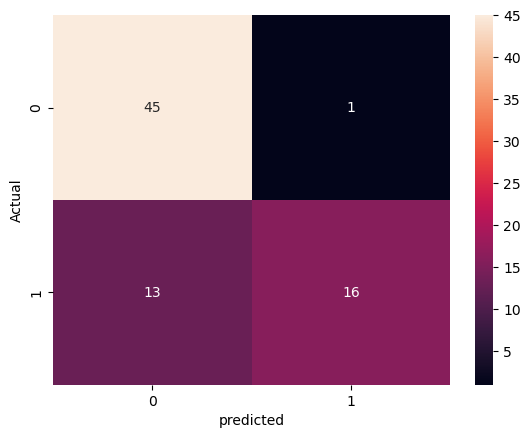

{'Accuracy': 81.333, 'Sensitivity': 55.172, 'Specificity': 97.826, 'Precision': 94.118, 'Miss_rate': 44.828, 'False_Discovery_Rate': 5.882, 'False_Omission_Rate': 22.414}
Cross-validation accuracy scores: [0.76 0.72 0.7  0.86 0.88]
Mean cross-validation accuracy: 0.7839999999999999
Feature importances: [(0.029808828915881963, 'PTEN_GRCh37_10:89692904-89692904_Missense-Mutation_SNP_C-C-G'), (0.01992025652893936, 'BCOR_GRCh37_X:39921444-39921444_Missense-Mutation_SNP_T-T-C'), (0.01932486132275673, 'CTNNB1_GRCh37_3:41266101-41266101_Missense-Mutation_SNP_C-C-A_C-C-T_C-C-G'), (0.016761334072535074, 'MB21D2_GRCh37_3:192516280-192516280_Frame-Shift-Del_DEL_T-T--'), (0.015923833539245646, 'PPP2R1A_GRCh37_19:52715971-52715971_Missense-Mutation_SNP_C-C-G_C-C-T'), (0.014645651762210728, 'ING1_GRCh37_13:111372025-111372025_Nonsense-Mutation_SNP_C-C-T'), (0.01460703304948683, "FYTTD1_GRCh37_3:197509857-197509857_3'UTR_DEL_A-A--"), (0.014199608418358177, 'RPL22_GRCh37_1:6257785-6257785_Frame-Shift-

In [207]:
top_10_features1 = random_forest_ensemble(df, useful_features1)

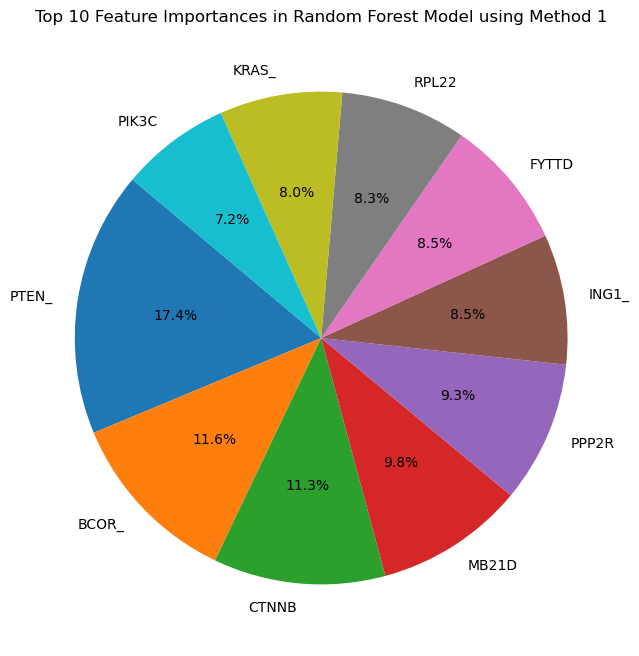

<Figure size 640x480 with 0 Axes>

In [208]:
importances, feature_names = zip(*top_10_features1)
feature_names = [name[:5] for name in feature_names]

plt.figure(figsize=(10, 8))  # You can adjust the size as needed
plt.pie(importances, labels=feature_names, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Feature Importances in Random Forest Model using Method 1')
plt.show()

plt.savefig('feature importance pie chart')

### Feature selection 2

#### I have selected out the features in which their occurence in NC is higher than their occurence is C by at most 2

In [209]:
C_df = df[df['class'].str.startswith('C')]
NC_df = df[df['class'].str.startswith('NC')]
c_list = []

c_nc_count = { }

for column in df.columns[1:]:
    C_sum = C_df[column].sum()
    NC_sum = NC_df[column].sum()

    if C_sum - NC_sum < 0 and NC_sum - C_sum > 2:
        c_list.append(column)

print(c_list)
print(len(c_list))

['DOK2_GRCh37_8:21767414-21767414_Missense-Mutation_SNP_C-C-T', 'CMKLR1_GRCh37_12:108686288-108686288_Missense-Mutation_SNP_C-C-T', 'CASD1_GRCh37_7:94185017-94185017_Frame-Shift-Del_DEL_T-T--', 'PPP2R1A_GRCh37_19:52716323-52716323_Missense-Mutation_SNP_C-C-T_C-C-A', 'PIK3CA_GRCh37_3:178936091-178936091_Missense-Mutation_SNP_G-G-A_G-G-C', 'AKT1_GRCh37_14:105246551-105246551_Missense-Mutation_SNP_C-C-T', 'TP53_GRCh37_17:7577120-7577120_Missense-Mutation_SNP_C-C-T_C-C-A', 'PIK3CA_GRCh37_3:178952085-178952085_Missense-Mutation_SNP_A-A-T_A-A-G', 'PPP2R1A_GRCh37_19:52715971-52715971_Missense-Mutation_SNP_C-C-G_C-C-T', 'PIK3CA_GRCh37_3:178936082-178936082_Missense-Mutation_SNP_G-G-A_G-G-C', 'TP53_GRCh37_17:7578406-7578406_Missense-Mutation_SNP_C-C-T', 'CCDC6_GRCh37_10:61612347-61612349_In-Frame-Del_DEL_TTC-TTC--', 'PPP2R1A_GRCh37_19:52716326-52716326_Missense-Mutation_SNP_G-G-T_G-G-C', 'TP53_GRCh37_17:7577559-7577559_Missense-Mutation_SNP_G-G-C_G-G-T_G-G-A', 'TP53_GRCh37_17:7577121-7577121_Mi

In [210]:
# Assume df is your DataFrame and c_list is your list of columns to exclude
selected_columns = df.columns[~df.columns.isin(c_list)]
filtered_df = df[selected_columns]

filtered_df

,class,GOT1_GRCh37_10:101163586-101163586_Missense-Mutation_SNP_C-C-T,TEX36_GRCh37_10:127371546-127371546_Nonsense-Mutation_SNP_G-G-A,KIAA1217_GRCh37_10:24810824-24810824_Missense-Mutation_SNP_C-C-T,SIRT1_GRCh37_10:69676051-69676051_Missense-Mutation_SNP_C-C-T,MYPN_GRCh37_10:69881845-69881845_Missense-Mutation_SNP_C-C-T,LARP4B_GRCh37_10:890939-890939_Frame-Shift-Del_DEL_T-T--,NPAT_GRCh37_11:108032094-108032094_Missense-Mutation_SNP_G-G-T_G-G-A,ARNTL_GRCh37_11:13402723-13402723_Silent_SNP_G-G-A,COPB1_GRCh37_11:14480092-14480092_Missense-Mutation_SNP_G-G-A_G-G-T,...,FBXO21_GRCh37_12:117624320-117624320_Frame-Shift-Del_DEL_A-A--,CLRN1_GRCh37_3:150644691-150644691_3'UTR_DEL_A-A--,VPS37A_GRCh37_8:17153149-17153149_3'UTR_DEL_A-A--,VANGL2_GRCh37_1:160398257-160398258_3'UTR_INS_----G,SRGAP3_GRCh37_3:9023972-9023972_3'UTR_DEL_A-A--,PTENP1_GRCh37_9:33674774-33674774_RNA_DEL_T-T--,KMT2C_GRCh37_7:151836804-151836804_Nonsense-Mutation_SNP_G-G-A,CDKN1C_GRCh37_11:2904846-2904846_3'UTR_DEL_T-T--,PIK3R2_GRCh37_19:18278070-18278070_Missense-Mutation_SNP_A-A-G,LMO7_GRCh37_13:76432354-76432354_3'UTR_SNP_C-C-T
0,NC1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,C1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NC2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NC3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NC4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,NC140,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
246,C107,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
247,NC141,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
248,C108,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### I filtered out the samples that dont have any mutations present, as they dont provide any useful information for our classification.

In [211]:
threshold = 1
filtered_df['mutation_count'] = filtered_df.drop('class', axis=1).sum(axis=1)
final_df = filtered_df[filtered_df['mutation_count'] >= threshold]

final_df = final_df.drop('mutation_count', axis=1)
final_df

/var/folders/_k/w9l87gnd6j97p2gthl_578lc0000gn/T/ipykernel_21563/3002133697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['mutation_count'] = filtered_df.drop('class', axis=1).sum(axis=1)


,class,GOT1_GRCh37_10:101163586-101163586_Missense-Mutation_SNP_C-C-T,TEX36_GRCh37_10:127371546-127371546_Nonsense-Mutation_SNP_G-G-A,KIAA1217_GRCh37_10:24810824-24810824_Missense-Mutation_SNP_C-C-T,SIRT1_GRCh37_10:69676051-69676051_Missense-Mutation_SNP_C-C-T,MYPN_GRCh37_10:69881845-69881845_Missense-Mutation_SNP_C-C-T,LARP4B_GRCh37_10:890939-890939_Frame-Shift-Del_DEL_T-T--,NPAT_GRCh37_11:108032094-108032094_Missense-Mutation_SNP_G-G-T_G-G-A,ARNTL_GRCh37_11:13402723-13402723_Silent_SNP_G-G-A,COPB1_GRCh37_11:14480092-14480092_Missense-Mutation_SNP_G-G-A_G-G-T,...,FBXO21_GRCh37_12:117624320-117624320_Frame-Shift-Del_DEL_A-A--,CLRN1_GRCh37_3:150644691-150644691_3'UTR_DEL_A-A--,VPS37A_GRCh37_8:17153149-17153149_3'UTR_DEL_A-A--,VANGL2_GRCh37_1:160398257-160398258_3'UTR_INS_----G,SRGAP3_GRCh37_3:9023972-9023972_3'UTR_DEL_A-A--,PTENP1_GRCh37_9:33674774-33674774_RNA_DEL_T-T--,KMT2C_GRCh37_7:151836804-151836804_Nonsense-Mutation_SNP_G-G-A,CDKN1C_GRCh37_11:2904846-2904846_3'UTR_DEL_T-T--,PIK3R2_GRCh37_19:18278070-18278070_Missense-Mutation_SNP_A-A-G,LMO7_GRCh37_13:76432354-76432354_3'UTR_SNP_C-C-T
0,NC1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,C1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NC2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NC4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,NC5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,NC139,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
245,NC140,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
246,C107,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
247,NC141,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [212]:
useful_features2 = final_df.drop(columns='class').columns

RandomForestClassifier(criterion='entropy', random_state=42)


Accuracy: 0.76
              precision    recall  f1-score   support

           0       0.73      0.98      0.83        46
           1       0.92      0.41      0.57        29

    accuracy                           0.76        75
   macro avg       0.82      0.70      0.70        75
weighted avg       0.80      0.76      0.73        75



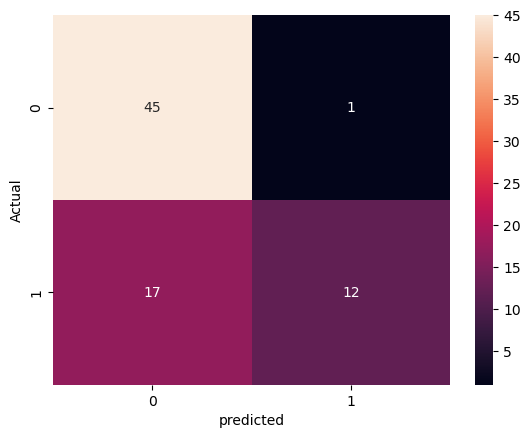

{'Accuracy': 76.0, 'Sensitivity': 41.379, 'Specificity': 97.826, 'Precision': 92.308, 'Miss_rate': 58.621, 'False_Discovery_Rate': 7.692, 'False_Omission_Rate': 27.419}
Cross-validation accuracy scores: [0.78 0.72 0.68 0.8  0.86]
Mean cross-validation accuracy: 0.768
Feature importances: [(0.03643829565553801, 'PTEN_GRCh37_10:89692904-89692904_Missense-Mutation_SNP_C-C-G'), (0.024892284113450732, 'CTNNB1_GRCh37_3:41266101-41266101_Missense-Mutation_SNP_C-C-A_C-C-T_C-C-G'), (0.024802373384450502, 'BCOR_GRCh37_X:39921444-39921444_Missense-Mutation_SNP_T-T-C'), (0.022208187071265262, 'MB21D2_GRCh37_3:192516280-192516280_Frame-Shift-Del_DEL_T-T--'), (0.0195778317326885, "FYTTD1_GRCh37_3:197509857-197509857_3'UTR_DEL_A-A--"), (0.014465240477630021, 'SOX17_GRCh37_8:55372518-55372518_Missense-Mutation_SNP_G-G-T'), (0.014457761036274936, 'KRAS_GRCh37_12:25398284-25398284_Missense-Mutation_SNP_C-C-A_C-C-T_C-C-G'), (0.013754987200498635, 'PIK3CA_GRCh37_3:178952074-178952074_Missense-Mutation_SNP

In [213]:
top_10_features2 = random_forest_ensemble(df, useful_features2)

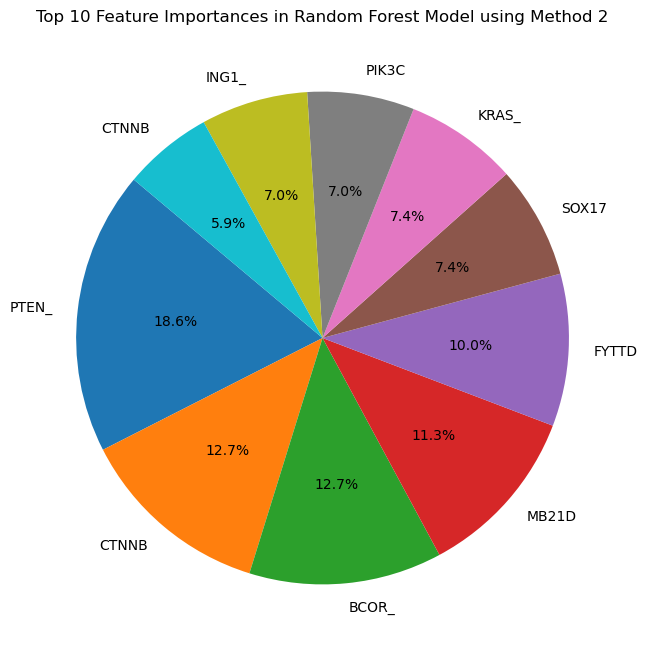

<Figure size 640x480 with 0 Axes>

In [214]:
importances, feature_names = zip(*top_10_features2)
feature_names = [name[:5] for name in feature_names]

plt.figure(figsize=(10, 8))  # You can adjust the size as needed
plt.pie(importances, labels=feature_names, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Feature Importances in Random Forest Model using Method 2')
plt.show()

plt.savefig('feature importance pie chart')